In [12]:
import pandas as pd
import os

directory_path = 'files/drugs/gene_drag'

signi_size = {}
total_size = {}
all_drugs = set()
sign_genes_drugs_mapping = pd.DataFrame(columns=['Selection', 'Association Name'])
gene_most_sign_drugs = pd.DataFrame(columns=['Selection', 'Association Name'])

for filename in os.listdir(directory_path):  
    file_path = os.path.join(directory_path, filename)
    data = pd.read_csv(file_path, sep='\t')
    filtered_data = data[data['Significance'] < 0.05]
    signi_size[data['Selection'][0]] = len(filtered_data)
    total_size[data['Selection'][0]] = len(data)
    all_drugs.update(filtered_data['Association Name'])
    sign_genes_drugs_mapping = pd.concat([sign_genes_drugs_mapping, filtered_data[['Selection', 'Association Name']]], ignore_index=True)
    most_significant = filtered_data.nsmallest(20, 'Significance')
    gene_most_sign_drugs = pd.concat([gene_most_sign_drugs, most_significant[['Selection', 'Association Name']]], ignore_index=True)

In [11]:
with open('files/sign_drugs_genes_mapping.sif', 'w') as file:
    for index, row in sign_genes_drugs_mapping.iterrows():
        line = f"{row['Selection']}\t-\t{row['Association Name']}\n"
        file.write(line)

In [15]:
with open('files/gene_most_sign_drugs.sif', 'w') as file:
    for index, row in gene_most_sign_drugs.iterrows():
        line = f"{row['Selection']}\t-\t{row['Association Name']}\n"
        file.write(line)

In [9]:
len(all_drugs)

4683

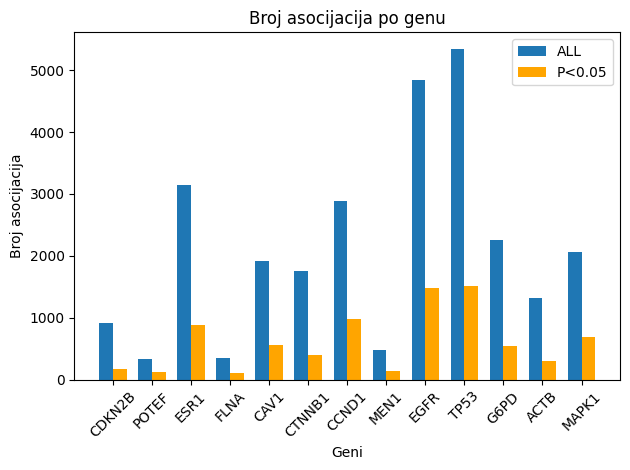

In [13]:
import numpy as np
import matplotlib.pyplot as plt

genes = list(total_size.keys())
all_counts = [total_size[gene] for gene in genes]
significant_counts = [signi_size[gene] for gene in genes]
bar_width = 0.35
ind = np.arange(len(genes))
fig, ax = plt.subplots()
all_bars = ax.bar(ind - bar_width/2, all_counts, bar_width, label='ALL')
signi_bars = ax.bar(ind + bar_width/2, significant_counts, bar_width, label='P<0.05', color='orange')

ax.set_title('Broj asocijacija po genu')
ax.set_xlabel('Geni')
ax.set_ylabel('Broj asocijacija')

ax.legend()

ax.set_xticks(ind)
ax.set_xticklabels(genes)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
directory_path = 'files/drugs/disease_drug'
disease_map = {}

for filename in os.listdir(directory_path):  
    file_path = os.path.join(directory_path, filename)
    data = pd.read_csv(file_path, sep='\t')
    filtered_data = data[data['Significance'] < 0.05]
    disease_map[filename] = set(filtered_data['Association Name'])

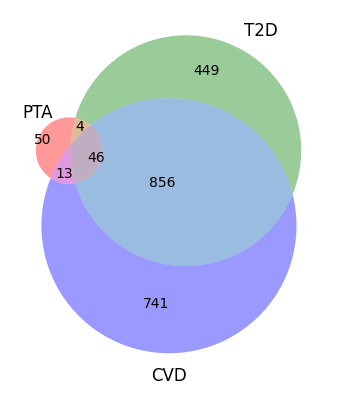

In [28]:
from matplotlib_venn import venn3
venn3([disease_map['PTA.txt'], disease_map['T2D.txt'], disease_map['CVD.txt']], ('PTA', 'T2D', 'CVD'))
plt.show()

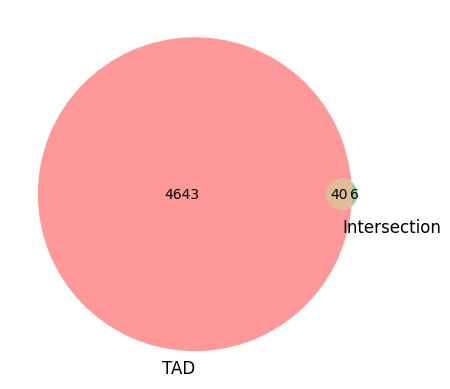

In [39]:
from matplotlib_venn import venn2
intersection = disease_map['PTA.txt'] & disease_map['T2D.txt'] & disease_map['CVD.txt'] 
venn2([all_drugs, intersection], ('TAD', 'Intersection'))
plt.show()

In [40]:
def set_to_string(s):
    return ','.join(map(str, sorted(s)))

with open('files/sets_data.txt', 'w') as file:
    file.write(set_to_string(disease_map['PTA.txt']) + '\n')
    file.write(set_to_string(disease_map['CVD.txt']) + '\n')
    file.write(set_to_string(disease_map['T2D.txt']) + '\n')
    file.write(set_to_string(all_drugs) + '\n')